# 다양한 Graph Neural Network을 이용해서 분자의 성질을 예측해보자.
----
이번 시간에는 pytorch_geometric의 다양한 Graph Neural Network layer를 이용해서 분자 물성 예측을 수행해본다.

이번 시간에는 더 많은 atom feature와 edge feature를 고려하여 GNN 학습을 수행해본다.

In [ ]:
#!pip install -q condacolab
#import condacolab
#condacolab.install()

#import condacolab
#condacolab.check()

https://www.rdkit.org/docs/GettingStartedInPython.html

In [ ]:
pip install rdkit

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 33.1/33.1 MB 20.5 MB/s eta 0:00:00


In [ ]:
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Not connected to a GPU')
else:
  print(gpu_info)

Tue Oct 15 07:52:32 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.104.05             Driver Version: 535.104.05   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  Tesla T4                       Off | 00000000:00:04.0 Off |                    0 |
| N/A   49C    P8              12W /  70W |      0MiB / 15360MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

## Installing pytorch geometric
----
pytorch geometric은 다양한 graph neural network 알고리즘을 미리 구현해놓은 library이다.

https://pytorch-geometric.readthedocs.io/en/latest/index.html

이를 이용하면 처음부터 pytorch를 이용하여 구현하는 것이 비해서 상대적으로 손쉽게 graph neural network을 구현할 수 있다.



In [ ]:
pip install torch_geometric

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 63.1/63.1 kB 3.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 51.4 MB/s eta 0:00:00


A graph is used to model pairwise relations (edges) between objects (nodes).

A single graph in PyG is described by an instance of **`torch_geometric.data.Data`**, which holds the following attributes by default:

**`data.x`**: Node feature matrix with shape `[num_nodes, num_node_features]`

**`data.edge_index`**: Graph connectivity in COO format with shape `[2, num_edges]` and type `torch.long`

**`data.edge_attr`**: Edge feature matrix with shape `[num_edges, num_edge_features]`

**`data.y`**: Target to train against (may have arbitrary shape), e.g., node-level targets of shape `[num_nodes, *]` or graph-level targets of shape `[1, *]`

**`data.pos`**: Node position matrix with shape `[num_nodes, num_dimensions]`

None of these attributes are required. In fact, the `Data` object is not even restricted to these attributes.

We can, e.g., extend it by `data.face` to save the connectivity of triangles from a 3D mesh in a tensor with shape `[3, num_faces]` and type torch.long.



We show a simple example of an unweighted and undirected graph with three nodes and four edges. Each node contains exactly one feature:

In [ ]:
import torch
import torch_geometric
from torch_geometric.data import Data # basic graph class

# edge index:
edge_index = torch.tensor([[0, 1, 1, 2],
                           [1, 0, 2, 1]], dtype=torch.long)

# node features:
x = torch.tensor([[-1], [0], [1]], dtype=torch.float)

# generate a graph using the Data class
data = Data(x=x, edge_index=edge_index)
data

Data(x=[3, 1], edge_index=[2, 4])

위의 코드는 아래의 그림과 같은 그래프를 나타낸다.
* 0번, 1번 노드가 연결되어 있음.
* 1번, 2번 노드가 연결되어 있음.
* 0번 노드의 특징은 [-1]로 표현됨.
* 1번 노드의 특징은 [0]으로 표현됨.
* 2번 노드의 특징은 [1]로 표현됨.

<img src="https://pytorch-geometric.readthedocs.io/en/latest/_images/graph.svg" width=600>

Note that **`edge_index`**, i.e. the tensor defining the source and target nodes of all edges, is not a list of index tuples.

If you want to write your indices in the form of **`[num_edges, 2]`**, you should transpose and call contiguous on it before passing them to the data constructor:

In [ ]:
# edge index
edge_index = torch.tensor([[0, 1],
                           [1, 0],
                           [1, 2],
                           [2, 1]], dtype=torch.long)

# node features
x = torch.tensor([[-1], [0], [1]], dtype=torch.float)

data = Data(x=x, edge_index=edge_index.t().contiguous())

data

Data(x=[3, 1], edge_index=[2, 4])

그래프 신경망을 이용하여 예측을 수행할 때, 크게 3가지 레벨에서 예측을 수행할 수 있다.

1. 노드 수준: 목적값 y값의 개수가 각 노드의 개수와 동일함.  
2. 연결 수준: 목적값 y값의 개수가 연결의 개수와 동일함.
3. 그래프 수준: 하나의 그래프 전체에서 하나의 목적값을 예측함.

<img src="https://velog.velcdn.com/images%2Fhixkix59%2Fpost%2F4249de11-3726-4e44-a025-8edd47019365%2Fimage.png" width=600>

Note that it is necessary that the elements in `edge_index` only hold indices in the range `{ 0, ..., num_nodes - 1}`. This is needed as we want our final data representation to be as compact as possible, e.g., we want to index the source and destination node features of the first edge `(0, 1)` via `x[0]` and `x[1]`, respectively. You can always check that your final Data objects fulfill these requirements by running [`validate()`](https://pytorch-geometric.readthedocs.io/en/latest/generated/torch_geometric.data.Data.html#torch_geometric.data.Data.validate). If the returned values is `True`, a given graph is valid:

In [ ]:
data.validate(raise_on_error=True)
data.num_nodes
data.num_edges

4

## Toxicity prediction using GCN
-------


In [ ]:
import rdkit
import rdkit.Chem as Chem
import numpy as np
import rdkit.Chem.AllChem as AllChem
import torch
import torch_geometric
from torch_geometric.data import Data

In [ ]:
import pandas as pd
import joblib

Pandas를 이용해서 데이터를 불러온다.


참고 사이트: https://wikidocs.net/book/3488

In [ ]:
!wget -O tox21.csv.gz https://deepchemdata.s3-us-west-1.amazonaws.com/datasets/tox21.csv.gz
df = pd.read_csv('tox21.csv.gz')

--2024-10-15 07:52:46--  https://deepchemdata.s3-us-west-1.amazonaws.com/datasets/tox21.csv.gz
Resolving deepchemdata.s3-us-west-1.amazonaws.com (deepchemdata.s3-us-west-1.amazonaws.com)... 3.5.163.195, 52.219.216.10, 3.5.163.14, ...
Connecting to deepchemdata.s3-us-west-1.amazonaws.com (deepchemdata.s3-us-west-1.amazonaws.com)|3.5.163.195|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 122925 (120K) [application/x-gzip]
Saving to: ‘tox21.csv.gz’

tox21.csv.gz        100%[===================>] 120.04K   224KB/s    in 0.5s    

2024-10-15 07:52:47 (224 KB/s) - ‘tox21.csv.gz’ saved [122925/122925]



In [ ]:
df

,NR-AR,NR-AR-LBD,NR-AhR,NR-Aromatase,NR-ER,NR-ER-LBD,NR-PPAR-gamma,SR-ARE,SR-ATAD5,SR-HSE,SR-MMP,SR-p53,mol_id,smiles
0,0.0,0.0,1.0,NaN,NaN,0.0,0.0,1.0,0.0,0.0,0.0,0.0,TOX3021,CCOc1ccc2nc(S(N)(=O)=O)sc2c1
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,0.0,NaN,0.0,0.0,TOX3020,CCN1C(=O)NC(c2ccccc2)C1=O
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,0.0,NaN,NaN,TOX3024,CC[C@]1(O)CC[C@H]2[C@@H]3CCC4=CCCC[C@@H]4[C@H]...
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,0.0,NaN,0.0,0.0,TOX3027,CCCN(CC)C(CC)C(=O)Nc1c(C)cccc1C
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,TOX20800,CC(O)(P(=O)(O)O)P(=O)(O)O
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7826,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,0.0,NaN,NaN,TOX2725,CCOc1nc2cccc(C(=O)O)c2n1Cc1ccc(-c2ccccc2-c2nnn...
7827,1.0,1.0,0.0,0.0,1.0,0.0,NaN,NaN,0.0,0.0,NaN,0.0,TOX2370,CC(=O)[C@H]1CC[C@H]2[C@@H]3CCC4=CC(=O)CC[C@]4(...
7828,1.0,1.0,0.0,0.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,TOX2371,C[C@]12CC[C@H]3[C@@H](CCC4=CC(=O)CC[C@@]43C)[C...
7829,1.0,1.0,0.0,NaN,1.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,TOX2377,C[C@]12CC[C@@H]3c4ccc(O)cc4CC[C@H]3[C@@H]1CC[C...


In [ ]:
df.dropna(axis='index', subset='NR-AR', inplace=True)

In [ ]:
df.reset_index(drop=True)

,NR-AR,NR-AR-LBD,NR-AhR,NR-Aromatase,NR-ER,NR-ER-LBD,NR-PPAR-gamma,SR-ARE,SR-ATAD5,SR-HSE,SR-MMP,SR-p53,mol_id,smiles
0,0.0,0.0,1.0,NaN,NaN,0.0,0.0,1.0,0.0,0.0,0.0,0.0,TOX3021,CCOc1ccc2nc(S(N)(=O)=O)sc2c1
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,0.0,NaN,0.0,0.0,TOX3020,CCN1C(=O)NC(c2ccccc2)C1=O
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,0.0,NaN,0.0,0.0,TOX3027,CCCN(CC)C(CC)C(=O)Nc1c(C)cccc1C
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,TOX20800,CC(O)(P(=O)(O)O)P(=O)(O)O
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,0.0,0.0,0.0,0.0,TOX5110,CC(C)(C)OOC(C)(C)CCC(C)(C)OOC(C)(C)C
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7260,0.0,0.0,0.0,0.0,NaN,0.0,NaN,NaN,0.0,0.0,NaN,0.0,TOX25184,CCCNCC(O)COc1ccccc1C(=O)CCc1ccccc1
7261,1.0,1.0,0.0,0.0,1.0,0.0,NaN,NaN,0.0,0.0,NaN,0.0,TOX2370,CC(=O)[C@H]1CC[C@H]2[C@@H]3CCC4=CC(=O)CC[C@]4(...
7262,1.0,1.0,0.0,0.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,TOX2371,C[C@]12CC[C@H]3[C@@H](CCC4=CC(=O)CC[C@@]43C)[C...
7263,1.0,1.0,0.0,NaN,1.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,TOX2377,C[C@]12CC[C@@H]3c4ccc(O)cc4CC[C@H]3[C@@H]1CC[C...


## 분자를 그래프로 나타내기

----
이번 예측에서는 H, B, C, N, O, F, P, S, Cl 만으로 이루어진 분자들만 고려하도록 하겠습니다.

이를 위해서 간단히 분자가 H, B, C, N, O, F, P, S, Cl만으로 구성되어 있는지를 확인하는 함수를 정의하겠습니다.

In [ ]:
def check_atoms(mol):
  """
  This function checks whether all atoms are valid
  """
  valid_atoms = ('B', 'C', 'N', 'O', 'F', 'P', 'S', 'Cl')
  flag = True
  for atm in mol.GetAtoms(): # 분자 안에 존재하는 모든 atom에 대해서 loop을 수행.
    if atm.GetSymbol() not in valid_atoms:
      flag = False
      break
  return flag

In [ ]:
from tqdm import tqdm
objective = []
for smi, score in tqdm(zip(df["smiles"], df["NR-AR"])):
  mol = Chem.MolFromSmiles(smi)
  if check_atoms(mol): # 모든 atom들이 원하는 atom들로만 구성되어 있을 때.
    objective.append((mol, score))
  else:
    continue

0it [00:00, ?it/s][07:52:47] WARNING: not removing hydrogen atom without neighbors
7265it [00:01, 3927.45it/s]


In [ ]:
print(len(objective))

6788


### Converting molecules to graphs using RDKit

----

분자를 그래프로 변환하여 나타낸다. 가능한 모든 atom / bond feature들을 뽑아낸다.

ref: https://pubs.acs.org/doi/abs/10.1021/acs.jmedchem.9b00959
https://www.rdkit.org/docs/source/rdkit.Chem.rdchem.html#rdkit.Chem.rdchem.HybridizationType

In [ ]:
def convert_mol_to_graph(mol, use_pos = False):

    #mol2 = Chem.AddHs(mol)   # 수소 붙임.
    mol2 = Chem.RemoveHs(mol) # 그래프를 간단히 하기 위해 수소 제거.

    n_bonds = len(mol2.GetBonds()) # 분자의 공유 결합 개수
    n_atoms = len(mol2.GetAtoms()) # 분자의 원자 개수

    edge_index = []
    edge_attr = []
    edge_weight = []

    # Edge attribute calculation
    for edge_idx in range(n_bonds): # 전체 공유 결합에 대해서 loop을 돌린다.
        bond = mol2.GetBondWithIdx(edge_idx) # 각 공유 결합에 대해서 시작 atom과 끝 atom의 인덱스를 확인.
        edge_index.append([bond.GetBeginAtomIdx(), bond.GetEndAtomIdx()])
        edge_index.append([bond.GetEndAtomIdx(), bond.GetBeginAtomIdx()]) # undirected graph를 만들기 위해서 순서를 바꿔서 edge를 2번 넣어준다.

        # BondType (4-dimensional one-hot)
        btype = bond.GetBondType() # 공유 결합의 종류.
        if btype == Chem.rdchem.BondType.SINGLE:
            bond_one_hot = [1, 0, 0, 0]
            edge_weight.extend([1.0, 1.0])
        elif btype == Chem.rdchem.BondType.AROMATIC:
            bond_one_hot = [0, 1, 0, 0]
            edge_weight.extend([1.5, 1.5])
        elif btype == Chem.rdchem.BondType.DOUBLE:
            bond_one_hot = [0, 0, 1, 0]
            edge_weight.extend([2.0, 2.0])
        elif btype == Chem.rdchem.BondType.TRIPLE:
            bond_one_hot = [0, 0, 0, 1]
            edge_weight.extend([3.0, 3.0])

        # BondStereo (6-dimensional one-hot)
        stype = bond.GetStereo()
        if stype == Chem.rdchem.BondStereo.STEREOANY:
          stereo_one_hot = [1, 0, 0, 0, 0, 0]
        elif stype == Chem.rdchem.BondStereo.STEREOCIS:
          stereo_one_hot = [0, 1, 0, 0, 0, 0]
        elif stype == Chem.rdchem.BondStereo.STEREOE:
          stereo_one_hot = [0, 0, 1, 0, 0, 0]
        elif stype == Chem.rdchem.BondStereo.STEREONONE:
          stereo_one_hot = [0, 0, 0, 1, 0, 0]
        elif stype == Chem.rdchem.BondStereo.STEREOTRANS:
          stereo_one_hot = [0, 0, 0, 0, 1, 0]
        elif stype == Chem.rdchem.BondStereo.STEREOZ:
          stereo_one_hot = [0, 0, 0, 0, 0, 1]

        # Is this bond included in a ring?
        if bond.IsInRing():
          ring_bond = 1
        else:
          ring_bond = 0

        # Is this bond a conjugated bond?
        if bond.GetIsConjugated():
          conjugate = 1
        else:
          conjugate = 0

        # In total 12-dimensional edge attribute
        # bond-type (4-dim), bondstereo (6-dim), (ring, conjugate)
        # Can you image more?
        attr = bond_one_hot + stereo_one_hot + [ring_bond, conjugate] # 12 차원의 공유 결합 속성.

        # 분자는 undirected graph이므로 edge가 두 번 정의된다.
        # 그러므로 동일한 attribute를 두 번 넣어주어야 한다.
        edge_attr.append(attr)
        edge_attr.append(attr)
    ## edge 속성 계산 완료

    ## node 속성 계산
    # RDKit으로 계산할 수 있는 Atom의 속성은 아래 링크에서 확인할 수 있다.
    # https://www.rdkit.org/docs/source/rdkit.Chem.rdchem.html#rdkit.Chem.rdchem.Atom
    #
    #.        0.   1.   2.   3.   4.   5.   6.   7.   8.
    #        'H', 'B', 'C', 'N', 'O', 'F', 'P', 'S', 'Cl'
    valid_atoms = {'H': 0, 'B':1, 'C':2, 'N':3, 'O':4, 'F':5, 'P':6, 'S':7, 'Cl':8}
    node_attr = []
    for atm_id in range(n_atoms):
        # Select an atom.
        atm = mol2.GetAtomWithIdx(atm_id)

        # Atom symbol check (9-dim)
        sym = atm.GetSymbol()
        atm_one_hot = [0] * len(valid_atoms) # 0이 9개 들어있는 리스트를 만든다.
        idx = valid_atoms[sym] # sym에 해당하는 원소 기호가 몇 번째에 있는지?
        atm_one_hot[idx] = 1   # 해당되는 원소의 위치만 1로 바꾼다.

        # Check hybridization (7-dim)
        hybrid = atm.GetHybridization()
        hybrid_one_hot = [0] * 7 # [0, 0, 0, 0, 0, 0, 0]
        if hybrid == Chem.HybridizationType.SP3:
          hybrid_one_hot[0] = 1
        elif hybrid == Chem.HybridizationType.SP2:
          hybrid_one_hot[1] = 1
        elif hybrid == Chem.HybridizationType.SP:
          hybrid_one_hot[2] = 1
        elif hybrid == Chem.HybridizationType.S:
          hybrid_one_hot[3] = 1
        elif hybrid == Chem.HybridizationType.SP3D:
          hybrid_one_hot[4] = 1
        elif hybrid == Chem.HybridizationType.SP3D2:
          hybrid_one_hot[5] = 1
        else: # hybridization이 제대로 정의되지 않은 나머지의 모든 경우.
          hybrid_one_hot[6] = 1

        # aromatic 인지 아닌지?  (True/False)
        if atm.GetIsAromatic():
          arom = 1
        else:
          arom = 0

        # ring 안에 존재하는지 아닌지? (True/False)
        if atm.IsInRing():
          ring_flag = 1
        else:
          ring_flag = 0

        # Degree (공유 결합의 개수)  (6-dim, one-hot)
        # 0, 1, 2, 3, 4, >=5
        degree_one_hot = [0, 0, 0, 0, 0, 0]
        degree = atm.GetTotalDegree()
        if degree >= 5: # 5개 이상의 공유 결합을 가지는 원자.
          degree_one_hot[5]=1
        else:
          degree_one_hot[degree]=1

        # Number of hydrogens (5-dim, one-hot)
        # 결합되어 있는 수소의 개수.
        # 0, 1, 2, 3, >=4
        num_h = atm.GetTotalNumHs()
        hydrogen_one_hot = [0, 0, 0, 0, 0]
        if num_h >= 4:
          hydrogen_one_hot[4] = 1
        else:
          hydrogen_one_hot[num_h] = 1

        # Chirality (4-dim, one-hot)
        chiral = atm.GetChiralTag()
        if chiral == Chem.rdchem.ChiralType.CHI_OTHER:
          chiral_one_hot = [1, 0, 0, 0]
        # Counter-clock-wise (반시계)
        elif chiral == Chem.rdchem.ChiralType.CHI_TETRAHEDRAL_CCW:
          chiral_one_hot = [0, 1, 0, 0]
        # Clockwise (시계방향)
        elif chiral == Chem.rdchem.ChiralType.CHI_TETRAHEDRAL_CW:
          chiral_one_hot = [0, 0, 1, 0]
        # Chirality 정의되지 않음.
        elif chiral == Chem.rdchem.ChiralType.CHI_UNSPECIFIED:
          chiral_one_hot = [0, 0, 0, 1]

        # 원자 특성 계산 [원자 symbol one-hot, 공유 결합 개수, 전체 valence의 개수 (explicit + implicit), is an atom aromatic (True/False)? ]
        # 더 추가 가능!
        # in total 25-dim.
        # 9-dim, 7-dim, 6-dim, 5-dim, 4-dim, 4-dim = 35-dim
        attr = atm_one_hot + hybrid_one_hot + \
                degree_one_hot + hydrogen_one_hot + \
                chiral_one_hot + \
                [arom, ring_flag, atm.GetFormalCharge(), atm.GetNumRadicalElectrons()]

        #print(atm_id, attr)
        node_attr.append(attr)
    ## node 속성 계산 완료

    # PyTorch Tensor로 변환.
    edge_attr = torch.tensor(edge_attr, dtype = torch.float)
    node_attr = torch.tensor(node_attr, dtype = torch.float)
    edge_index = torch.tensor(edge_index, dtype = torch.long)
    edge_index = edge_index.t().contiguous()
    edge_weight = torch.tensor(edge_weight, dtype = torch.float)

    if use_pos: # 만일 3D 좌표 정보를 사용한다면
        val = AllChem.EmbedMolecule(mol2)
        if val !=0:
          print(f"Error while generating 3D: {Chem.MolToSmiles(mol)}")
          return None

        pos_list = [] # this is optional
        for atm_id in range(n_atoms):
          # Get Atomic Position.
          atm_pos = mol2.GetConformer(0).GetAtomPosition(atm_id)
          crd = [atm_pos.x, atm_pos.y, atm_pos.z]
          pos_list.append(crd)

        pos = torch.tensor(pos_list, dtype=torch.float)
    else:
      pos = None
    #print(edge_attr.shape)
    #print(node_attr.shape)
    #print(edge_index.shape)

    return edge_index, node_attr, edge_attr, pos, edge_weight

In [ ]:
edge_index, x, edge_attr, pos, edge_weight = convert_mol_to_graph(objective[0][0])

In [ ]:
d0 = Data(x = x, edge_index = edge_index, edge_attr = edge_attr, pos = pos, edge_weight = edge_weight)

In [ ]:
print(d0)

Data(x=[16, 35], edge_index=[2, 34], edge_attr=[34, 12], edge_weight=[34])


In [ ]:
d0.num_nodes

16

## 이제 분자들을 하나씩 PyG의 Data type으로 변환해봅시다.
----

In [ ]:
data_list = []
for mol, score in tqdm(objective):
    result = convert_mol_to_graph(mol)
    if result is None:
        continue

    # Extract node and edge informations
    edge_index, node_attr, edge_attr, pos, edge_weight = result
    y = torch.tensor([[score]], dtype = torch.float)

    dtmp = Data(x = node_attr, pos = pos, edge_index = edge_index, edge_attr = edge_attr, edge_weight = edge_weight, y = y)

    data_list.append(dtmp)

100%|██████████| 6788/6788 [00:06<00:00, 1094.94it/s]


분자들이 graph로 변환 되었다~!

In [ ]:
from torch_geometric.loader import DataLoader

In [ ]:
import random
random.seed(12345)
random.shuffle(data_list)

In [ ]:
n_data = len(data_list)
n_train = int(n_data*0.8)
n_test = int(n_data*0.1)

train_set, val_set, test_set = data_list[0:n_train], data_list[n_train:n_train+n_test], data_list[n_train+n_test:]
print(f"Number of training set: {len(train_set)}")
print(f"Number of Validaation set: {len(val_set)}")
print(f"Number of test set: {len(test_set)}")

Number of training set: 5430
Number of Validaation set: 678
Number of test set: 680


In [ ]:
train_loader = DataLoader(train_set, batch_size=100, shuffle=True, drop_last = False)
test_loader = DataLoader(test_set, batch_size=100, shuffle=True, drop_last = False)
val_loader = DataLoader(val_set, batch_size=100, shuffle=False, drop_last = False)

In [ ]:
print(train_loader)

In [ ]:
print(len(train_loader.dataset))
print(len(test_loader.dataset))
print(len(val_loader.dataset))

5430
680
678


In [ ]:
for batch in train_loader:
    print(batch)
    print(batch.batch)
    print(batch.num_graphs)
    print(batch.num_node_features)
    break

DataBatch(x=[2037, 35], edge_index=[2, 4294], edge_attr=[4294, 12], y=[100, 1], edge_weight=[4294], batch=[2037], ptr=[101])
tensor([ 0,  0,  0,  ..., 99, 99, 99])
100
35


In [ ]:
data = data_list[0]
print(data.keys)

<bound method BaseData.keys of Data(x=[23, 35], edge_index=[2, 44], edge_attr=[44, 12], y=[1, 1], edge_weight=[44])>


In [ ]:
data.num_node_features

35

## 실제로 Graph Convolutional Network을 정의해봅시다.

----

Convolution 3층과 마지막 1차원의 출력을 내어놓는 네트워크 입니다.


In [ ]:
import torch
from torch.nn import Linear
import torch.nn.functional as F
from torch_geometric.nn import GCNConv
from torch_geometric.nn import global_mean_pool

class myGCN(torch.nn.Module):
    def __init__(self, in_channel=35, hidden_layer_size=70):
        super().__init__()
        self.conv1 = GCNConv(in_channel, hidden_layer_size) # 가장 기본적인 graph convolution model, https://pytorch-geometric.readthedocs.io/en/latest/modules/nn.html#torch_geometric.nn.conv.GCNConv
        self.conv2 = GCNConv(hidden_layer_size, hidden_layer_size)
        self.conv3 = GCNConv(hidden_layer_size, hidden_layer_size)
        #self.conv4 = GCNConv(hidden_layer_size, hidden_layer_size)
        #self.conv5 = GCNConv(hidden_layer_size, hidden_layer_size)
        self.lin1 = Linear(hidden_layer_size, int(hidden_layer_size/2))
        self.lin2 = Linear(int(hidden_layer_size/2), 1)

    def forward(self, data):
        x, edge_index, batch, edge_weight = data.x, data.edge_index, data.batch, data.edge_weight

        x = self.conv1(x, edge_index)
        x = F.gelu(x)
        x = F.dropout(x, training=self.training)

        x = self.conv2(x, edge_index)
        x = F.gelu(x)
        x = F.dropout(x, training=self.training)

        x = self.conv3(x, edge_index)
        x = F.gelu(x)

        #x = self.conv4(x, edge_index)
        #x = F.elu(x)

        #x = self.conv5(x, edge_index)
        #x = F.elu(x)

        # READOUT
        x = global_mean_pool(x, batch) # 전체의 node feature의 평균 값을 취한다. # [batch_size, hidden_channels]

        x = self.lin1(x) # 70 dim -> 35-dim
        x = F.elu(x)
        x = self.lin2(x) # 35 dim -> 1-dim

        return x

In [ ]:
from prettytable import PrettyTable

def count_parameters(model):
    table = PrettyTable(["Modules", "Parameters"])
    total_params = 0
    for name, parameter in model.named_parameters():
        if not parameter.requires_grad: continue
        param = parameter.numel()
        table.add_row([name, param])
        total_params+=param
    print(table)
    print(f"Total Trainable Params: {total_params}")
    return total_params

In [ ]:
if torch.cuda.is_available():
    device = torch.device('cuda')
else:
    device = torch.device('cpu')
print(device)
model = myGCN(in_channel = 35, hidden_layer_size = 70)
model.to(device)

cuda


myGCN(
  (conv1): GCNConv(35, 70)
  (conv2): GCNConv(70, 70)
  (conv3): GCNConv(70, 70)
  (lin1): Linear(in_features=70, out_features=35, bias=True)
  (lin2): Linear(in_features=35, out_features=1, bias=True)
)

In [ ]:
print(model)

myGCN(
  (conv1): GCNConv(35, 70)
  (conv2): GCNConv(70, 70)
  (conv3): GCNConv(70, 70)
  (lin1): Linear(in_features=70, out_features=35, bias=True)
  (lin2): Linear(in_features=35, out_features=1, bias=True)
)


In [ ]:
count_parameters(model)

+------------------+------------+
|     Modules      | Parameters |
+------------------+------------+
|    conv1.bias    |     70     |
| conv1.lin.weight |    2450    |
|    conv2.bias    |     70     |
| conv2.lin.weight |    4900    |
|    conv3.bias    |     70     |
| conv3.lin.weight |    4900    |
|   lin1.weight    |    2450    |
|    lin1.bias     |     35     |
|   lin2.weight    |     35     |
|    lin2.bias     |     1      |
+------------------+------------+
Total Trainable Params: 14981


14981

In [ ]:
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

#criterion = torch.nn.MSELoss()
criterion = torch.nn.BCEWithLogitsLoss()

In [ ]:
import sys

In [ ]:
def train():

    model.train()

    train_loss = 0.0
    for idx, batch in enumerate(train_loader):
      # Make predictions
      out = model(batch.to(device))

      # calculate loss value
      loss = criterion(out, batch.y)

      # perform backpropagation
      loss.backward()

      # update parameters
      optimizer.step()  # Update parameters based on gradients.

      # reset gradients
      optimizer.zero_grad()  # Clear gradients.

      train_loss += loss.item()
      if idx % 10 == 0:
        print(f"Batch index: {idx:5d}\tLoss: {loss:.5f} \t train_loss: {train_loss:.5f}")

    train_loss /= len(train_loader.dataset)
    print(f"Train Loss: {train_loss:.5f}")

## Define test function
------


use torchmetrics

In [ ]:
pip install torchmetrics

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 869.5/869.5 kB 43.1 MB/s eta 0:00:00


In [ ]:
from torchmetrics.classification import Accuracy
from torchmetrics.classification import BinaryAccuracy
#from torcheval.metrics.functional import binary_accuracy

In [ ]:
print(len(train_loader.dataset))

5430


### Test function to evaluate accuracy and loss values.
-------


In [ ]:
# initialize metric
metric = BinaryAccuracy().to(device)

def test(loader):
    model.eval()

    out_all = []
    true = []
    loss_val = 0.0

    for data in loader:  # Iterate in batches over the training/test dataset.
        out = model(data.to(device))
        loss = criterion(out, data.y.to(device))
        loss_val += loss.item() # sum over batches

        # calculate accuracy of this batch
        acc_tmp = metric(out.to(device), data.y.to(device))

        # save all labels
        true += data.y.flatten().tolist()

        # save all predicted values
        out_all += F.sigmoid(out).flatten().tolist()

    # metric on all batches using custom accumulation
    acc = metric.compute()
    metric.reset()
    # print(f"\tAccuracy: {acc.cpu():.3f}")

    loss_val /= len(loader.dataset)
    # print(f"\tLoss: {loss_val:.5f}\n")

    return acc.cpu(), out_all, true, loss_val  # Derive ratio of correct predictions.

In [ ]:
train_acc_list = []
val_acc_list = []
test_acc_list = []

train_loss_list = []
val_loss_list = []

n_epoch = 20

for epoch in range(n_epoch):
    print("="*100)
    print("Epoch: ", epoch)

    train()

    train_acc, out_tmp, true_tmp, train_loss = test(train_loader)
    train_acc_list.append(train_acc)
    train_loss_list.append(train_loss)

    val_acc, val_pred, val_true, val_loss = test(val_loader)
    val_acc_list.append(val_acc)
    val_loss_list.append(val_loss)

    print("-"*100)
    print(f'End of Epoch: {epoch:03d}, Train Acc: {train_acc:.4f}, Val Acc: {val_acc:.4f}, Train loss: {train_loss:.5f}, Val loss: {val_loss:.5f}')
    print("-"*100)


Epoch:  1
Batch index:     0	Loss: 0.63290 	 train_loss: 0.63290
Batch index:    10	Loss: 0.52469 	 train_loss: 6.40001
Batch index:    20	Loss: 0.36018 	 train_loss: 10.52283
Batch index:    30	Loss: 0.13435 	 train_loss: 12.68483
Batch index:    40	Loss: 0.17107 	 train_loss: 14.83009
Batch index:    50	Loss: 0.11378 	 train_loss: 16.90343
Train Loss: 0.00324
----------------------------------------------------------------------------------------------------
End of Epoch: 001, Train Acc: 0.9536, Val Acc: 0.9705, Train loss: 0.00187, Val loss: 0.00143
----------------------------------------------------------------------------------------------------
Epoch:  2
Batch index:     0	Loss: 0.23067 	 train_loss: 0.23067
Batch index:    10	Loss: 0.07861 	 train_loss: 1.92185
Batch index:    20	Loss: 0.38509 	 train_loss: 4.00496
Batch index:    30	Loss: 0.13914 	 train_loss: 5.77777
Batch index:    40	Loss: 0.10411 	 train_loss: 7.60848
Batch index:    50	Loss: 0.12584 	 train_loss: 9.26958


In [ ]:
#---------------------
# Test on the final test set.
print("\nFinal test results on test set")
test_acc, out_all, true_all, test_loss = test(test_loader)
test_acc_list.append(test_acc)

print(f"Test set accuracy: {test_acc:.5f}")
print(f"test set loss: {test_loss:.5f}")


Final test results on test set
Test set accuracy: 0.96765
test set loss: 0.00139


## Loss 값의 변화를 plot 해보자.
----


In [ ]:
import matplotlib.pyplot as plt

def draw_acc_change(train_loss, val_loss, test_loss=None):
  plt.figure(figsize=(8,8)) # 빈 그림을 정의
  plt.plot(train_loss, color = 'r', label = 'Train accuracy') # training loss
  plt.plot(val_loss, color = 'b', label = 'Val accuracy') # validation set loss
  if test_loss is not None:
    plt.plot(test_loss, color = 'g',  label = 'Test accuracy') # test set loss
  plt.xlabel("Epoch")
  plt.ylabel("Accuracy")

  #plt.ylim(0, 1.1)
  plt.legend(loc='best') # label을 표시 하겠다.

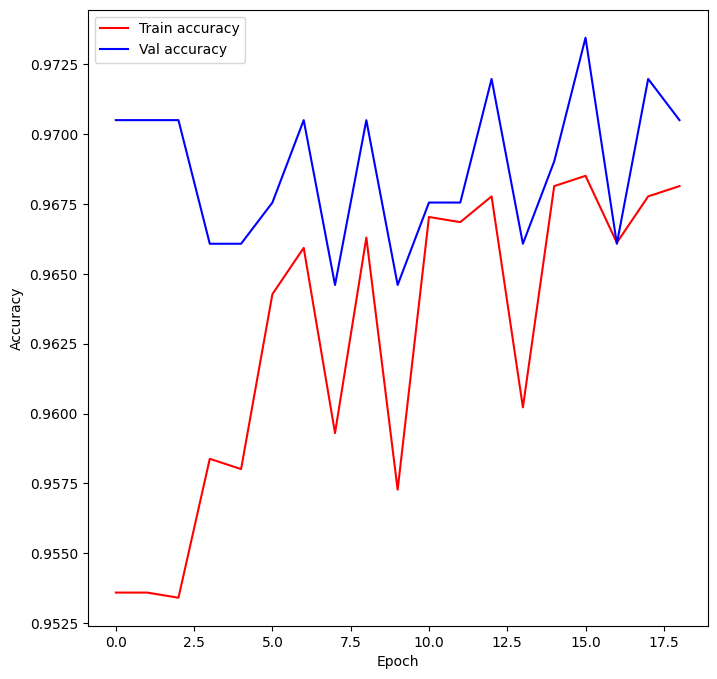

In [ ]:
draw_acc_change(train_acc_list, val_acc_list)

In [ ]:
def draw_loss_change(train_loss, val_loss, test_loss=None):
  plt.figure(figsize=(8,8)) # 빈 그림을 정의
  plt.plot(train_loss, color = 'r', label = 'Train loss') # training loss
  plt.plot(val_loss, color = 'b', label = 'Val loss') # validation set loss
  if test_loss is not None:
    plt.plot(test_loss, color = 'g',  label = 'Test loss') # test set loss
  plt.xlabel("Epoch")
  plt.ylabel("Loss")
  #plt.ylim(0, 1.1)
  plt.legend(loc='best') # label을 표시 하겠다.

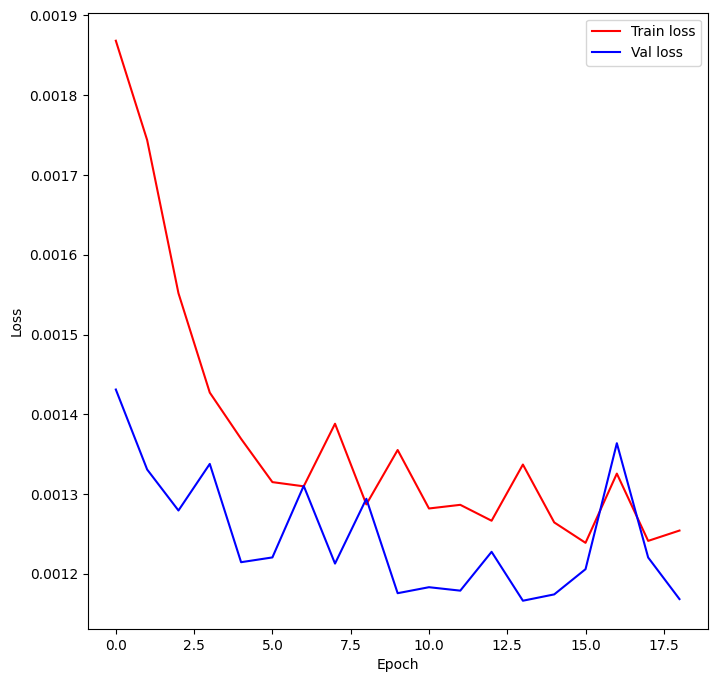

In [ ]:
draw_loss_change(train_loss_list, val_loss_list)

In [ ]:
import sklearn
from sklearn.metrics import f1_score, roc_auc_score

f1 = f1_score(true_all, [1 if x>= 0.5 else 0 for x in out_all])
auc = roc_auc_score(true_all, out_all)

print(f"F1-score: {f1:.4f}")
print(f"ROC_AUC: {auc:.4f}")

F1-score: 0.4737
ROC_AUC: 0.7948


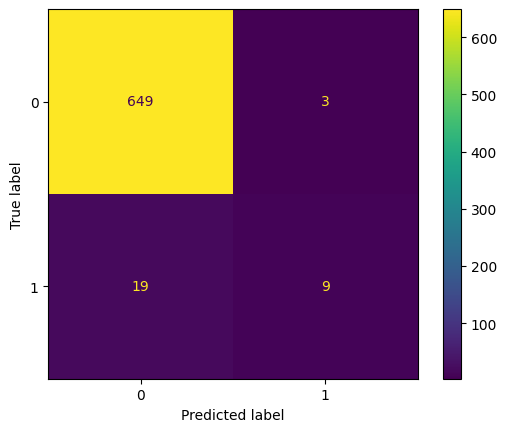

In [ ]:
import matplotlib.pyplot as plt
from sklearn.datasets import make_classification
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC

out_binary = [1 if x >= 0.5 else 0 for x in out_all]
cm = confusion_matrix(true_all, out_binary, labels=(0,1))
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=(0,1))
disp.plot()

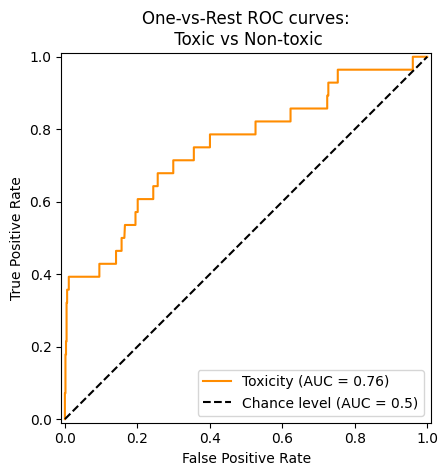

In [ ]:
from sklearn.metrics import RocCurveDisplay

display = RocCurveDisplay.from_predictions(
    true_all,
    out_all,
    name=f"Toxicity",
    color="darkorange",
    plot_chance_level=True,
)
_ = display.ax_.set(
    xlabel="False Positive Rate",
    ylabel="True Positive Rate",
    title="One-vs-Rest ROC curves:\n Toxic vs Non-toxic",
)

In [ ]:
from sklearn.metrics import PrecisionRecallDisplay

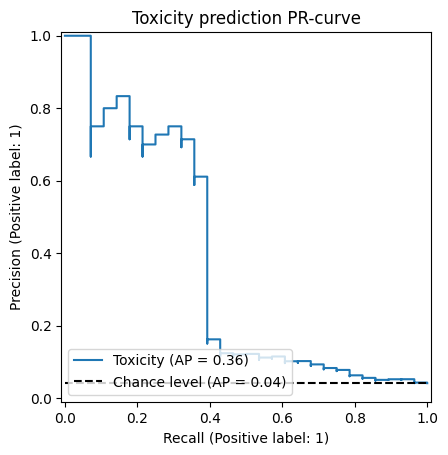

In [ ]:
display = PrecisionRecallDisplay.from_predictions(
    true_all,
    out_all,
    name = "Toxicity",
    plot_chance_level=True,
)

_ = display.ax_.set(
    title="Toxicity prediction PR-curve", )


# GCN layer에 edge weight 정보를 넣으면 더 좋아질까?
-----

* Single bond 는 가중치 1
* Double bond 는 가중치 2
* Triple bond 는 가중치 3
* Aromatic은 가중치 1.5

이런식으로 edge_weight를 정의하였음.


In [ ]:
import torch
from torch.nn import Linear
import torch.nn.functional as F
from torch_geometric.nn import GCNConv
from torch_geometric.nn import global_mean_pool

class mymodel2(torch.nn.Module):
    def __init__(self):
        super().__init__()
        n_feat = 35
        self.conv1 = GCNConv(n_feat, n_feat*2) # 가장 기본적인 graph convolution model, https://pytorch-geometric.readthedocs.io/en/latest/modules/nn.html#torch_geometric.nn.conv.GCNConv
        self.conv2 = GCNConv(n_feat*2, n_feat*2)
        self.conv3 = GCNConv(n_feat*2, n_feat*2)
        #self.conv4 = GCNConv(n_feat*2, n_feat*2)
        #self.conv5 = GCNConv(n_feat*2, n_feat*2)
        self.lin1 = Linear(n_feat*2, n_feat)
        self.lin2 = Linear(n_feat, 1)

    def forward(self, data):
        x, edge_index, batch, edge_weight = data.x, data.edge_index, data.batch, data.edge_weight

        x = self.conv1(x, edge_index, edge_weight) # 이번에는 edge_weight를 고려해서 학습한다, edge_weight는 optional한 정보.
        x = F.gelu(x)
        x = F.dropout(x, training=self.training)

        x = self.conv2(x, edge_index, edge_weight)
        x = F.gelu(x)
        x = F.dropout(x, training=self.training)

        x = self.conv3(x, edge_index, edge_weight)
        x = F.gelu(x)

        #x = self.conv4(x, edge_index, edge_weight)
        #x = F.elu(x)
        #x = self.conv5(x, edge_index, edge_weight)
        #x = F.elu(x)

        x = global_mean_pool(x, batch) # 전체의 node feature의 평균 값을 취한다. # [batch_size, hidden_channels]
        x = self.lin1(x)
        x = F.leaky_relu(x)
        x = self.lin2(x)

        return x

In [ ]:
if torch.cuda.is_available():
    device = torch.device('cuda')
else:
    device = torch.device('cpu')

print(device)
model = mymodel2()
model.to(device)

cuda


mymodel2(
  (conv1): GCNConv(35, 70)
  (conv2): GCNConv(70, 70)
  (conv3): GCNConv(70, 70)
  (lin1): Linear(in_features=70, out_features=35, bias=True)
  (lin2): Linear(in_features=35, out_features=1, bias=True)
)

In [ ]:
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
#criterion = torch.nn.MSELoss()
criterion = torch.nn.BCEWithLogitsLoss()

In [ ]:
n_epoch = 20
train_loss_all = []
val_loss_all = []

for epoch in range(1, n_epoch):
    print("="*100 + "\nEpoch: ", epoch)

    train()

    train_acc, out_tmp, true_tmp, train_loss = test(train_loader)
    train_loss_all.append(train_loss)

    val_acc, val_pred, val_true, val_loss = test(val_loader)
    val_loss_all.append(val_loss)

    print("-"*100)
    print(f'Epoch: {epoch:03d}, Train Acc: {train_acc:.4f}, Val Acc: {val_acc:.4f}, Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}')


Epoch:  1
Batch index:     0	Loss: 0.75971 	 train_loss: 0.75971
Batch index:    10	Loss: 0.69309 	 train_loss: 7.99186
Batch index:    20	Loss: 0.54640 	 train_loss: 14.25441
Batch index:    30	Loss: 0.31206 	 train_loss: 18.26166
Batch index:    40	Loss: 0.15367 	 train_loss: 20.27474
Batch index:    50	Loss: 0.10049 	 train_loss: 22.26946
Train Loss: 0.00423
----------------------------------------------------------------------------------------------------
Epoch: 001, Train Acc: 0.9536, Val Acc: 0.9705, Train Loss: 0.0019, Val Loss: 0.0014
Epoch:  2
Batch index:     0	Loss: 0.15868 	 train_loss: 0.15868
Batch index:    10	Loss: 0.26605 	 train_loss: 2.13243
Batch index:    20	Loss: 0.13101 	 train_loss: 4.01297
Batch index:    30	Loss: 0.16446 	 train_loss: 5.83591
Batch index:    40	Loss: 0.12139 	 train_loss: 7.32278
Batch index:    50	Loss: 0.23562 	 train_loss: 9.24657
Train Loss: 0.00182
------------------------------------------------------------------------------------------

In [ ]:
test_acc, out_all, true_all, test_loss = test(test_loader)
print(f"Test Accuracy: {test_acc:.5f}")
print(f"Test Loss: {test_loss:.5f}")

Test Accuracy: 0.96618
Test Loss: 0.00135


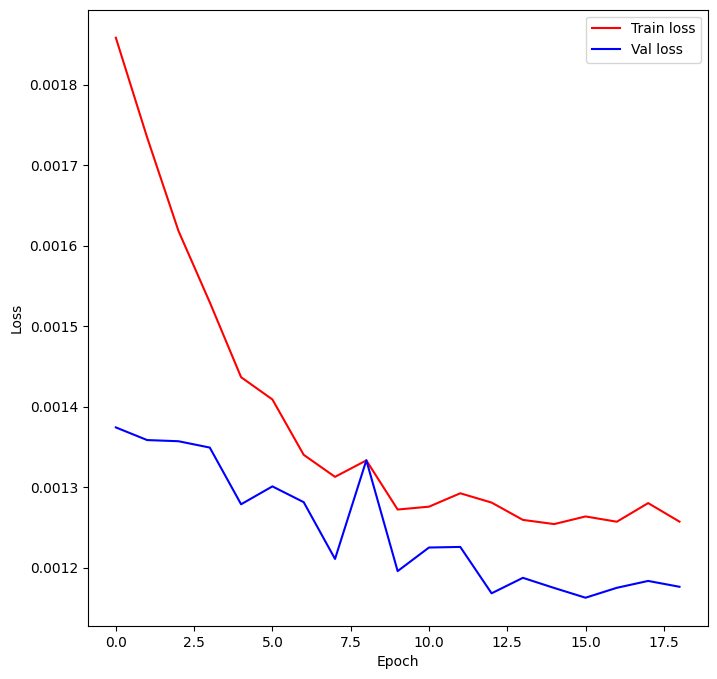

In [ ]:
draw_loss_change(train_loss_all, val_loss_all)

In [ ]:
import sklearn
from sklearn.metrics import f1_score, roc_auc_score
f1 = f1_score(true_all, [1 if x>= 0.5 else 0 for x in out_all])
auc = roc_auc_score(true_all, out_all)
print(f"F1-score: {f1:.4f}")
print(f"ROC_AUC: {auc:.4f}")

F1-score: 0.4103
ROC_AUC: 0.7779


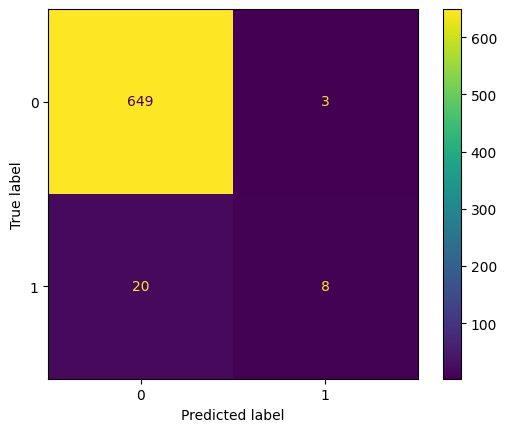

In [ ]:
out_binary = [1 if x >= 0.5 else 0 for x in out_all]
cm = confusion_matrix(true_all, out_binary, labels=(0,1))
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=(0,1))
disp.plot()

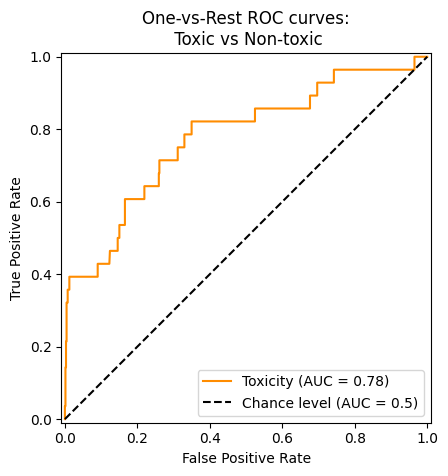

In [ ]:
from sklearn.metrics import RocCurveDisplay

display = RocCurveDisplay.from_predictions(
    true_all,
    out_all,
    name=f"Toxicity",
    color="darkorange",
    plot_chance_level=True,
)
_ = display.ax_.set(
    xlabel="False Positive Rate",
    ylabel="True Positive Rate",
    title="One-vs-Rest ROC curves:\n Toxic vs Non-toxic",
)

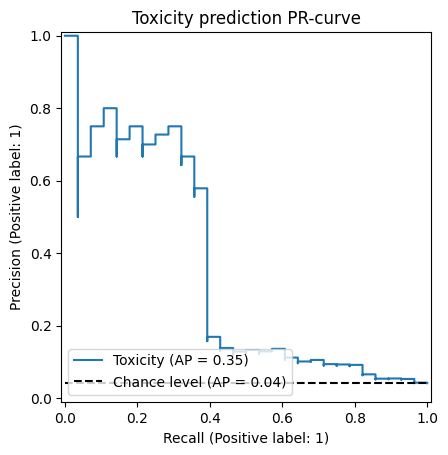

In [ ]:
display = PrecisionRecallDisplay.from_predictions(
    true_all,
    out_all,
    name = "Toxicity",
    plot_chance_level=True,
)

_ = display.ax_.set(
    title="Toxicity prediction PR-curve",
)

# Graph Attentive Network
----
GCNConv 말고 다른 graph convolution layer인 Graph Attentive Network의 성능을 알아봅시다.


In [ ]:
import torch
from torch.nn import Linear
import torch.nn.functional as F
from torch_geometric.nn import GCNConv, GATConv
from torch_geometric.nn import global_mean_pool

class my_GAT_model(torch.nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = GATConv(35, 70) # 가장 기본적인 graph convolution model, https://pytorch-geometric.readthedocs.io/en/latest/modules/nn.html#torch_geometric.nn.conv.GCNConv
        self.conv2 = GATConv(70, 70)
        self.conv3 = GATConv(70, 70)
        #self.conv4 = GATConv(70, 70)
        #self.conv5 = GATConv(70, 70)

        self.lin1 = Linear(70, 35)
        self.lin2 = Linear(35, 1)

    def forward(self, data):
        x, edge_index, batch, edge_attr, edge_weight = data.x, data.edge_index, data.batch, data.edge_attr, data.edge_weight

        x = self.conv1(x, edge_index) # node_attribute와 edge_index만 사용하고 있음. -> edge의 attribute는 사용하고 있지 않음.
        x = F.gelu(x)
        x = F.dropout(x, training=self.training)

        x = self.conv2(x, edge_index)
        x = F.gelu(x)

        x = self.conv3(x, edge_index)
        x = F.gelu(x)

        x = global_mean_pool(x, batch) # 전체의 node feature의 평균 값을 취한다. # [batch_size, hidden_channels]
        x = F.gelu(self.lin1(x))
        x = self.lin2(x)

        return x

In [ ]:
model = my_GAT_model()
model.to(device)

my_GAT_model(
  (conv1): GATConv(35, 70, heads=1)
  (conv2): GATConv(70, 70, heads=1)
  (conv3): GATConv(70, 70, heads=1)
  (lin1): Linear(in_features=70, out_features=35, bias=True)
  (lin2): Linear(in_features=35, out_features=1, bias=True)
)

In [ ]:
count_parameters(model)

+------------------+------------+
|     Modules      | Parameters |
+------------------+------------+
|  conv1.att_src   |     70     |
|  conv1.att_dst   |     70     |
|    conv1.bias    |     70     |
| conv1.lin.weight |    2450    |
|  conv2.att_src   |     70     |
|  conv2.att_dst   |     70     |
|    conv2.bias    |     70     |
| conv2.lin.weight |    4900    |
|  conv3.att_src   |     70     |
|  conv3.att_dst   |     70     |
|    conv3.bias    |     70     |
| conv3.lin.weight |    4900    |
|   lin1.weight    |    2450    |
|    lin1.bias     |     35     |
|   lin2.weight    |     35     |
|    lin2.bias     |     1      |
+------------------+------------+
Total Trainable Params: 15401


15401

In [ ]:
optimizer = torch.optim.Adam(model.parameters(), lr=0.005)
#criterion = torch.nn.MSELoss()
criterion = torch.nn.BCEWithLogitsLoss()

In [ ]:
train_acc_list = []
test_acc_list = []
val_acc_list = []

n_epoch = 20

for epoch in range(1, n_epoch):
    print("="*100)
    print("Epoch: ", epoch)
    train()

    train_acc, out_tmp, true_tmp, train_loss = test(train_loader)
    train_acc_list.append(train_acc)

    val_acc, val_pred, val_true, val_loss = test(val_loader)
    val_acc_list.append(val_acc)

    print("-"*100)
    print(f'Epoch: {epoch:03d}, Train Acc: {train_acc:.4f}, Val Acc: {val_acc:.4f}, Test Acc: {test_acc:.4f}')

Epoch:  1
Batch index:     0	Loss: 0.72948 	 train_loss: 0.72948
Batch index:    10	Loss: 0.05038 	 train_loss: 4.76542
Batch index:    20	Loss: 0.13655 	 train_loss: 7.11825
Batch index:    30	Loss: 0.25864 	 train_loss: 9.10257
Batch index:    40	Loss: 0.25814 	 train_loss: 11.02115
Batch index:    50	Loss: 0.12574 	 train_loss: 12.91891
Train Loss: 0.00251
----------------------------------------------------------------------------------------------------
Epoch: 001, Train Acc: 0.9536, Val Acc: 0.9705, Test Acc: 0.9662
Epoch:  2
Batch index:     0	Loss: 0.13120 	 train_loss: 0.13120
Batch index:    10	Loss: 0.10423 	 train_loss: 1.76090
Batch index:    20	Loss: 0.08125 	 train_loss: 3.04933
Batch index:    30	Loss: 0.16548 	 train_loss: 4.48086
Batch index:    40	Loss: 0.03375 	 train_loss: 5.70266
Batch index:    50	Loss: 0.11340 	 train_loss: 7.37583
Train Loss: 0.00150
----------------------------------------------------------------------------------------------------
Epoch: 002,

In [ ]:
test_acc, out_all, true_all, test_loss = test(test_loader)
print(f"Test Accuracy: {test_acc:.5f}")
print(f"Test Loss: {test_loss:.5f}")

Test Accuracy: 0.96618
Test Loss: 0.00144


In [ ]:
import sklearn
from sklearn.metrics import f1_score, roc_auc_score
f1 = f1_score(true_all, [1 if x>= 0.5 else 0 for x in out_all])
auc = roc_auc_score(true_all, out_all)
print(f"F1-score: {f1:.4f}")
print(f"ROC_AUC: {auc:.4f}")

F1-score: 0.3784
ROC_AUC: 0.7313


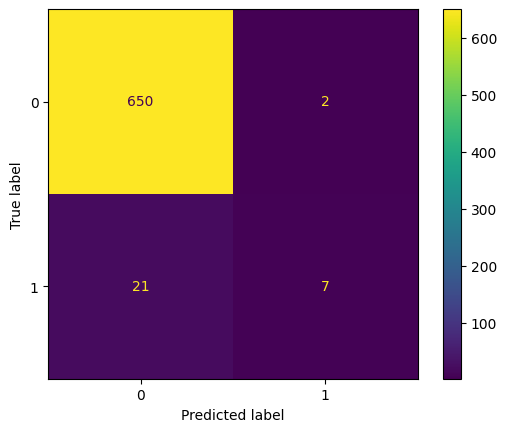

In [ ]:
out_binary = [1 if x >= 0.5 else 0 for x in out_all]
cm = confusion_matrix(true_all, out_binary, labels=(0,1))
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=(0,1))
disp.plot()

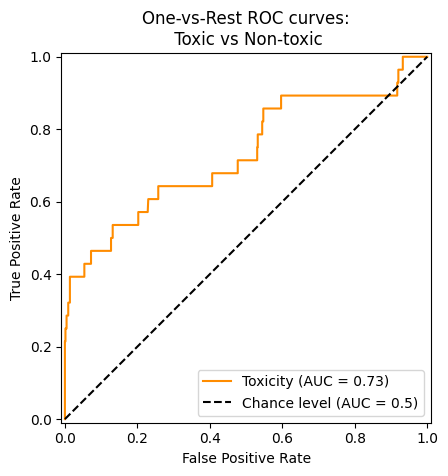

In [ ]:
from sklearn.metrics import RocCurveDisplay

display = RocCurveDisplay.from_predictions(
    true_all,
    out_all,
    name=f"Toxicity",
    color="darkorange",
    plot_chance_level=True,
)
_ = display.ax_.set(
    xlabel="False Positive Rate",
    ylabel="True Positive Rate",
    title="One-vs-Rest ROC curves:\n Toxic vs Non-toxic",
)

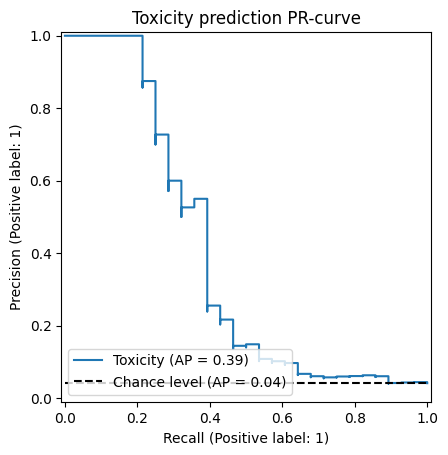

In [ ]:
display = PrecisionRecallDisplay.from_predictions(
    true_all,
    out_all,
    name = "Toxicity",
    plot_chance_level=True,
)

_ = display.ax_.set(
    title="Toxicity prediction PR-curve",
)

# 어떤 layer가 어떤 정보를 사용하는가?
----
## GNN Cheatsheet

https://pytorch-geometric.readthedocs.io/en/latest/notes/cheatsheet.html#

In [ ]:
import torch
from torch.nn import Linear
import torch.nn.functional as F
from torch_geometric.nn import GCNConv, GATConv, TransformerConv, GATv2Conv
from torch_geometric.nn import global_mean_pool

class myGATv2Conv_model(torch.nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = GATv2Conv(35, 70, edge_dim=12) # 가장 기본적인 graph convolution model, https://pytorch-geometric.readthedocs.io/en/latest/modules/nn.html#torch_geometric.nn.conv.GCNConv
        self.conv2 = GATv2Conv(70, 70, edge_dim=12)
        self.conv3 = GATv2Conv(70, 70, edge_dim=12)
        #self.conv4 = GATv2Conv(70, 70, edge_dim=12)
        #self.conv5 = GATv2Conv(70, 70, edge_dim=12)

        self.lin1 = Linear(70, 35)
        self.lin2 = Linear(35, 1)

    def forward(self, data):
        x, edge_index, batch, edge_attr, edge_weight = data.x, data.edge_index, data.batch, data.edge_attr, data.edge_weight

        x = self.conv1(x, edge_index, edge_attr)
        x = F.gelu(x)
        x = F.dropout(x, training=self.training)

        x = self.conv2(x, edge_index, edge_attr)
        x = F.gelu(x)

        x = self.conv3(x, edge_index, edge_attr)
        x = F.gelu(x)

        #x = self.conv4(x, edge_index, edge_attr)
        #x = F.gelu(x)
        #x = self.conv5(x, edge_index, edge_attr)
        #x = F.gelu(x)

        x = global_mean_pool(x, batch) # 전체의 node feature의 평균 값을 취한다. # [batch_size, hidden_channels]
        x = F.gelu(self.lin1(x))
        x = self.lin2(x)

        return x

In [ ]:
model = myGATv2Conv_model()
model.to(device)

myGATv2Conv_model(
  (conv1): GATv2Conv(35, 70, heads=1)
  (conv2): GATv2Conv(70, 70, heads=1)
  (conv3): GATv2Conv(70, 70, heads=1)
  (lin1): Linear(in_features=70, out_features=35, bias=True)
  (lin2): Linear(in_features=35, out_features=1, bias=True)
)

In [ ]:
count_parameters(model)

+-----------------------+------------+
|        Modules        | Parameters |
+-----------------------+------------+
|       conv1.att       |     70     |
|       conv1.bias      |     70     |
|   conv1.lin_l.weight  |    2450    |
|    conv1.lin_l.bias   |     70     |
|   conv1.lin_r.weight  |    2450    |
|    conv1.lin_r.bias   |     70     |
| conv1.lin_edge.weight |    840     |
|       conv2.att       |     70     |
|       conv2.bias      |     70     |
|   conv2.lin_l.weight  |    4900    |
|    conv2.lin_l.bias   |     70     |
|   conv2.lin_r.weight  |    4900    |
|    conv2.lin_r.bias   |     70     |
| conv2.lin_edge.weight |    840     |
|       conv3.att       |     70     |
|       conv3.bias      |     70     |
|   conv3.lin_l.weight  |    4900    |
|    conv3.lin_l.bias   |     70     |
|   conv3.lin_r.weight  |    4900    |
|    conv3.lin_r.bias   |     70     |
| conv3.lin_edge.weight |    840     |
|      lin1.weight      |    2450    |
|       lin1.bias       |

30381

In [ ]:
optimizer = torch.optim.Adam(model.parameters(), lr=0.005)
#criterion = torch.nn.MSELoss()
criterion = torch.nn.BCEWithLogitsLoss()

In [ ]:
train_acc_list = []
test_acc_list = []
val_acc_list = []
for epoch in range(1, 20):
    print("="*100)
    print("Epoch: ", epoch)

    train()

    train_acc, out_tmp, true_tmp, train_loss = test(train_loader)
    train_acc_list.append(train_acc)

    test_acc, out_all, true_all, test_loss = test(test_loader)
    test_acc_list.append(test_acc)

    val_acc, val_pred, val_true, val_loss = test(val_loader)
    val_acc_list.append(val_acc)

    print("-"*100)
    print(f'Epoch: {epoch:03d}, Train Acc: {train_acc:.4f}, Val Acc: {val_acc:.4f}, Test Acc: {test_acc:.4f}')

Epoch:  1
Batch index:     0	Loss: 0.07533 	 train_loss: 0.07533
Batch index:    10	Loss: 0.09132 	 train_loss: 1.63765
Batch index:    20	Loss: 0.15959 	 train_loss: 2.98177
Batch index:    30	Loss: 0.17335 	 train_loss: 4.25718
Batch index:    40	Loss: 0.11759 	 train_loss: 5.65851
Batch index:    50	Loss: 0.12659 	 train_loss: 7.18402
Train Loss: 0.00142
----------------------------------------------------------------------------------------------------
Epoch: 001, Train Acc: 0.9654, Val Acc: 0.9705, Test Acc: 0.9618
Epoch:  2
Batch index:     0	Loss: 0.09832 	 train_loss: 0.09832
Batch index:    10	Loss: 0.15428 	 train_loss: 1.64328
Batch index:    20	Loss: 0.14549 	 train_loss: 2.83905
Batch index:    30	Loss: 0.08023 	 train_loss: 4.04711
Batch index:    40	Loss: 0.09835 	 train_loss: 5.26593
Batch index:    50	Loss: 0.20532 	 train_loss: 6.55957
Train Loss: 0.00133
----------------------------------------------------------------------------------------------------
Epoch: 002, T

In [ ]:
test_acc, out_all, true_all, test_loss = test(test_loader)
print(f"Test Accuracy: {test_acc:.5f}")
print(f"Test Loss: {test_loss:.5f}")

Test Accuracy: 0.97059
Test Loss: 0.00131


In [ ]:
import sklearn
from sklearn.metrics import f1_score, roc_auc_score
f1 = f1_score(true_all, [1 if x>= 0.5 else 0 for x in out_all])
auc = roc_auc_score(true_all, out_all)
print(f"F1-score: {f1:.4f}")
print(f"ROC_AUC: {auc:.4f}")

F1-score: 0.4737
ROC_AUC: 0.7948


# (Exercise) Build you own network using other layer, GraphConv layer

또 다른 모델인 GraphConv layer를 이용해서 모델을 만들어 보라~

https://pytorch-geometric.readthedocs.io/en/latest/modules/nn.html#torch_geometric.nn.conv.GraphConv

In [ ]:
import torch
from torch.nn import Linear
import torch.nn.functional as F
from torch_geometric.nn import GCNConv, GATConv, TransformerConv, GATv2Conv, GraphConv
from torch_geometric.nn import global_mean_pool

class my_GraphConv_model(torch.nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = GraphConv(...) # 가장 기본적인 graph convolution model, https://pytorch-geometric.readthedocs.io/en/latest/modules/nn.html#torch_geometric.nn.conv.GCNConv
        self.conv2 = GraphConv(...)
        self.conv3 = GraphConv(...)
        self.conv4 = GraphConv(...)
        self.conv5 = GraphConv(...)

        self.lin1 = Linear(...)
        self.lin2 = Linear(...)

    def forward(self, data):
        x, edge_index, batch, edge_attr, edge_weight = data.x, data.edge_index, data.batch, data.edge_attr, data.edge_weight

        x = self.conv1(x, edge_index, edge_attr)
        x = F.gelu(x)
        x = F.dropout(x, training=self.training)
        x = self.conv2(x, edge_index, edge_attr)
        x = F.gelu(x)
        x = self.conv3(x, edge_index, edge_attr)
        x = F.gelu(x)
        #x = self.conv4(x, edge_index, edge_attr)
        #x = F.gelu(x)
        #x = self.conv5(x, edge_index, edge_attr)
        #x = F.gelu(x)

        x = global_mean_pool(x, batch) # 전체의 node feature의 평균 값을 취한다. # [batch_size, hidden_channels]
        x = F.gelu(self.lin1(x))
        x = self.lin2(x)

        return x

In [ ]:
model = my_GraphConv_model()
print(model)
count_parameters(model)

In [ ]:
optimizer = torch.optim.Adam(model.parameters(), lr=0.005)
#criterion = torch.nn.MSELoss()
criterion = torch.nn.BCEWithLogitsLoss()

In [ ]:
for epoch in range(1, 20):
    print("="*100)
    print("Epoch: ", epoch)
    train()
    train_acc, out_tmp, true_tmp, train_loss = test(train_loader)
    test_acc, out_all, true_all, test_loss = test(test_loader)
    val_acc, val_pred, val_true, val_loss = test(val_loader)
    print("-"*100)
    print(f'Epoch: {epoch:03d}, Train Acc: {train_acc:.4f}, Val Acc: {val_acc:.4f}, Test Acc: {test_acc:.4f}')